In [18]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cross_validation 
from sklearn.learning_curve import learning_curve 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
#from sklearn.metrics import metrics 
from sklearn.cross_validation import train_test_split 
from sklearn.grid_search import GridSearchCV 
from sklearn.cross_validation import ShuffleSplit 
import seaborn 
import urllib


In [19]:
np.random.seed(sum(map(ord, "aesthetics"))) 
seaborn.set_context('notebook') 
seaborn.set_style(style='darkgrid')


## Prepring the dataSet
Downloading and divinding our dataset into train-data and test-data

In [20]:
url="http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric" 
raw_data = urllib.request.urlopen(url) 
credit=np.genfromtxt(raw_data) 
X,y = credit[:,:-1], credit[:,-1:].squeeze()
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)



(1000, 24) (1000,)


## Fit trees
Verifing what's the best parameters to our estimator

In [21]:
def fit_trees(n_jobs, max_depth, n_estimators): 
    estimator = RandomForestClassifier() 
    cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2) 
    
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=dict(n_estimators=n_estimators, max_depth=max_depth), n_jobs=n_jobs, scoring='f1')
    
    classifier.fit(X_train, y_train)
    
    print ("Best Estimator learned through GridSearch")
    print (classifier.best_estimator_)
    
    return cv, classifier.best_estimator_.max_depth, classifier.best_estimator_.n_estimators

## Getting the best parameters

In [22]:
max_depth=np.linspace(5,10,5) 
n_estimators=[10, 100, 500, 1000] 
 
cv,max_depth,n_estimators=fit_trees(n_jobs=10, max_depth=max_depth, n_estimators=n_estimators)

Best Estimator learned through GridSearch
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7.5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## Plot of the test and traning learning curve.

In [23]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure() 
    
    plt.title(title) 
    plt.xlabel("Training examples") 
    plt.ylabel("Score") 
    
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes) 
    train_scores_mean = np.mean(train_scores, axis=1) 
    train_scores_std = np.std(train_scores, axis=1) 
    test_scores_mean = np.mean(test_scores, axis=1) 
    test_scores_std = np.std(test_scores, axis=1) 
    
    plt.grid() 
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r") 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g") 
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score") 
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score") 
    
    plt.legend(loc="best") 
    return plt 

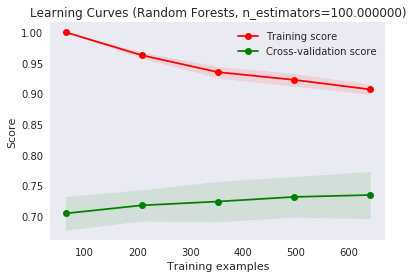

In [24]:
title = "Learning Curves (Random Forests, n_estimators=%.6f)" %(n_estimators) 
estimator = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth) 
plot_learning_curve(estimator, title, X_train, y_train, cv=cv) 
plt.show()

In [25]:
#Let's call fit on the estimator so we can look at feature importances. 
estimator.fit(X_train,y_train) 
#Running predictions on Test 
y_pred=estimator.predict([X_test[0]]) 
print('data: ', X_test[0])
print('class: ', y_test[0])
if y_pred == 1.0:
    print('Prediction: Good')
else:
    print('Prediction: Bad')

data:  [ 2. 11.  4. 13.  4.  3.  2.  4.  3. 40.  3.  2.  1.  1.  1.  1.  0.  1.
  0.  0.  1.  0.  0.  1.]
class:  1.0
Prediction: Good


In [26]:
print ("Statlog Credit Data - Feature Importances\n") 
print (estimator.feature_importances_ )

Statlog Credit Data - Feature Importances

[0.16578366 0.10053652 0.07925043 0.11436314 0.07487357 0.0543224
 0.03591178 0.03100725 0.04669122 0.09149254 0.02825351 0.01760412
 0.01114057 0.01458792 0.00480532 0.02723587 0.01736117 0.01392945
 0.01028731 0.0138614  0.01833821 0.00384753 0.01144748 0.01306763]


Top 10 Feature importances
1. feature 0 (0.165784)
2. feature 3 (0.114363)
3. feature 1 (0.100537)
4. feature 9 (0.091493)
5. feature 2 (0.079250)
6. feature 4 (0.074874)
7. feature 5 (0.054322)
8. feature 8 (0.046691)
9. feature 6 (0.035912)
10. feature 7 (0.031007)


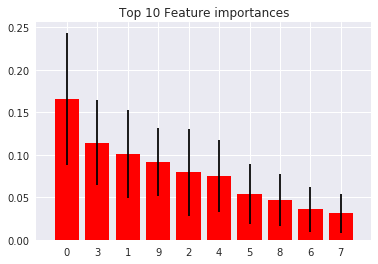

Mean Feature Importance 0.041667


In [27]:
# Calculate the feature ranking - Top 10 
importances = estimator.feature_importances_ 
std = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0) 
indices = np.argsort(importances)[::-1] 

print("Top 10 Feature importances") 
for f in range(10): 
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])) 
    
#Plot the feature importances of the forest 
indices=indices[:10] 
plt.figure() 
plt.title("Top 10 Feature importances") 
plt.bar(range(10), importances[indices], color="r", yerr=std[indices], align="center") 
plt.xticks(range(10), indices) 
plt.xlim([-1, 10]) 
plt.show() 
#Mean Feature Importance 
print ("Mean Feature Importance %.6f" %np.mean(importances))